In [1]:
import os

os.chdir(os.path.dirname("../"))

In [2]:
import warnings

warnings.filterwarnings("ignore")

# deepOF data exploration

Given a dataset, this notebook allows the user to 

* Load and process the dataset using deepof.data
* Visualize data quality with interactive plots
* Visualize training instances as multi-timepoint scatter plots with interactive configurations
* Visualize training instances as video clips with interactive configurations

In [3]:
import deepof.data
import deepof.utils
import numpy as np
import pandas as pd
import ruptures as rpt
import tensorflow as tf

from ipywidgets import interact, widgets
from IPython import display
from matplotlib.animation import FuncAnimation
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Define and run project

In [4]:
exclude_bodyparts = tuple([""])

In [5]:
# Use deepof to load a project
proj = deepof.data.project(
    path="../../Desktop/deepoftesttemp/",
    arena_dims=[380],
    arena_detection="rule-based",
    exclude_bodyparts=exclude_bodyparts,
    interpolate_outliers=True,
    smooth_alpha=9,
).run()

Loading trajectories...
Smoothing trajectories...
Interpolating outliers...
Iterative imputation of ocluded bodyparts...
Computing distances...
Computing angles...
Done!


### 2. Inspect dataset quality

In [6]:
all_quality = pd.concat([tab for tab in proj.get_quality().values()])

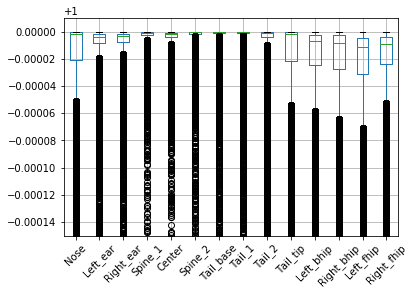

In [7]:
all_quality.boxplot(rot=45)
plt.ylim(0.99985, 1.00001)
plt.show()

In [8]:
@interact(quality_top=(0.0, 1.0, 0.01))
def low_quality_tags(quality_top):
    pd.DataFrame(
        pd.melt(all_quality)
        .groupby("bodyparts")
        .value.apply(lambda y: sum(y < quality_top) / len(y) * 100)
    ).sort_values(by="value", ascending=False).plot.bar(rot=45)

    plt.xlabel("body part")
    plt.ylabel("Tags with quality under {} (%)".format(quality_top * 100))
    plt.tight_layout()
    plt.legend([])
    plt.show()

interactive(children=(FloatSlider(value=0.5, description='quality_top', max=1.0, step=0.01), Output()), _dom_c…

In the cell above, you see the percentage of labels per body part which have a quality lower than the selected value (0.50 by default) **before** preprocessing. The values are taken directly from DeepLabCut.

### 3. Get coordinates, distances and angles

And get speed, acceleration and jerk for each

In [9]:
# Get coordinates, speeds, accelerations and jerks for positions
position_coords = proj.get_coords(center="Center", align="Spine_1", align_inplace=True)
position_speeds = proj.get_coords(center="Center", speed=1)
position_accels = proj.get_coords(center="Center", speed=2)
position_jerks = proj.get_coords(center="Center", speed=3)

In [10]:
# Get coordinates, speeds, accelerations and jerks for distances
distance_coords = proj.get_distances()
distance_speeds = proj.get_distances(speed=1)
distance_accels = proj.get_distances(speed=2)
distance_jerks = proj.get_distances(speed=3)

In [11]:
# Get coordinates, speeds, accelerations and jerks for angles
angle_coords = proj.get_angles()
angle_speeds = proj.get_angles(speed=1)
angle_accels = proj.get_angles(speed=2)
angle_jerks = proj.get_angles(speed=3)

### 4. Analyse smoothing

In [15]:
@interact(test=position_coords.keys(), 
          bpart = set([i[0] for i in list(position_coords.values())[0].columns]), 
          max_obs=(100, 1000), 
          smooth_degree=widgets.IntSlider(min=2, max=11, value=9), 
          smooth_wlen=widgets.IntSlider(min=11, max=101, step=2, value=11))
def plot_smoothing(test, bpart, max_obs, smooth_degree, smooth_wlen):
    
    fig = plt.figure(figsize=(12, 8))
    
    no_smooth = deepof.data.project(
    path="../../Desktop/deepoftesttemp/",
    arena_dims=[380],
    arena_detection="rule-based",
    exclude_bodyparts=exclude_bodyparts,
    interpolate_outliers=True,
    smooth_alpha=None,
    ).run(verbose=0).get_coords(center="Center", align="Spine_1", align_inplace=True)
    
    no_smooth_coords = no_smooth[test].iloc[:max_obs, :].loc[:, bpart]
    smooth_coords = savgol_filter(no_smooth_coords, smooth_wlen, smooth_degree, axis=0)
    
    plt.plot(no_smooth_coords, linestyle="--", label="no smoothing")
    plt.plot(smooth_coords, color="red", label="savgol, poly={}, wlen={}".format(smooth_degree, smooth_wlen))
    
    plt.title("SavGol smoothing exploration")
    plt.xlabel("Time")
    plt.ylabel("Coordinate value")

    plt.legend()
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='test', options=('Test 1_s11', 'Test 1_s12'), value='Test 1_s11'), …

### 5. Display training instances

In [16]:
random_exp = np.random.choice(list(position_coords.keys()), 1)[0]


@interact(time_slider=(0.0, 15000, 25), length_slider=(10, 100, 5))
def plot_mice_across_time(time_slider, length_slider):

    plt.figure(figsize=(10, 10))

    for bpart in position_coords[random_exp].columns.levels[0]:
        if bpart != "Center":
            sns.scatterplot(
                data=position_coords[random_exp].loc[
                    time_slider : time_slider + length_slider - 1, bpart
                ],
                x="x",
                y="y",
                label=bpart,
                palette=sns.color_palette("tab10"),
            )

    plt.title("Positions across time for centered data")
    plt.legend(
        fontsize=15,
        bbox_to_anchor=(1.5, 1),
        title="Body part",
        title_fontsize=18,
        shadow=False,
        facecolor="white",
    )

    plt.ylim(-100, 60)
    plt.xlim(-60, 60)
    plt.show()

interactive(children=(FloatSlider(value=7500.0, description='time_slider', max=15000.0, step=25.0), IntSlider(…

The figure above is a multi time-point scatter plot. The time_slider allows you to scroll across the video, and the length_slider selects the number of time-points to include. The idea is to intuitively visualize the data that goes into a training instance for a given preprocessing setting.

In [17]:
# Auxiliary animation functions


def plot_mouse_graph(instant_x, instant_y, ax, edges):
    """Generates a graph plot of the mouse"""
    plots = []
    for edge in edges:
        (temp_plot,) = ax.plot(
            [float(instant_x[edge[0]]), float(instant_x[edge[1]])],
            [float(instant_y[edge[0]]), float(instant_y[edge[1]])],
            color="#006699",
            linewidth=2.0,
        )
        plots.append(temp_plot)
    return plots


def update_mouse_graph(x, y, plots, edges):
    """Updates the graph plot to enable animation"""

    for plot, edge in zip(plots, edges):
        plot.set_data(
            [float(x[edge[0]]), float(x[edge[1]])],
            [float(y[edge[0]]), float(y[edge[1]])],
        )

In [18]:
random_exp = np.random.choice(list(position_coords.keys()), 1)[0]
print(random_exp)


@interact(time_slider=(0.0, 15000, 25), length_slider=(10, 100, 5))
def animate_mice_across_time(time_slider, length_slider):

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    edges = deepof.utils.connect_mouse_topview()

    for bpart in exclude_bodyparts:
        if bpart:
            edges.remove_node(bpart)

    for limb in ["Left_fhip", "Right_fhip", "Left_bhip", "Right_bhip"]:
        edges.remove_edge("Center", limb)
        if ("Tail_base", limb) in list(edges.edges()):
            edges.remove_edge("Tail_base", limb)

    edges = edges.edges()

    data = position_coords[random_exp].loc[
        time_slider : time_slider + length_slider - 1, :
    ]

    data["Center", "x"] = 0
    data["Center", "y"] = 0

    init_x = data.xs("x", level=1, axis=1, drop_level=False).iloc[0, :]
    init_y = data.xs("y", level=1, axis=1, drop_level=False).iloc[0, :]

    plots = plot_mouse_graph(init_x, init_y, ax, edges)
    scatter = ax.scatter(x=np.array(init_x), y=np.array(init_y), color="#006699",)

    # Update data in main plot
    def animation_frame(i):
        # Update scatter plot
        x = data.xs("x", level=1, axis=1, drop_level=False).iloc[i, :]
        y = data.xs("y", level=1, axis=1, drop_level=False).iloc[i, :]

        scatter.set_offsets(np.c_[np.array(x), np.array(y)])
        update_mouse_graph(x, y, plots, edges)

        return scatter

    animation = FuncAnimation(
        fig, func=animation_frame, frames=length_slider, interval=75,
    )

    ax.set_title("Positions across time for centered data")
    ax.set_ylim(-90, 60)
    ax.set_xlim(-60, 60)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    video = animation.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()

Test 1_s11


interactive(children=(FloatSlider(value=7500.0, description='time_slider', max=15000.0, step=25.0), IntSlider(…

The figure above displays exactly the same data as the multi time-point scatter plot, but in the form of a video (one training instance at the time).

### 6. Detect changepoints

In [ ]:
test_rupt = np.array(position_coords["Test 1_s11"])

In [ ]:
test_rupt.shape

In [ ]:
algo = rpt.Pelt(model="rbf", min_size=10, jump=1).fit(test_rupt)
result = algo.predict(pen=3)

In [ ]:
len(result)

In [ ]:
cut = 1000
cut = result[np.argmin(np.abs(np.array(result) - cut))]
print("cut:", cut)
rpt.display(test_rupt[:cut], [i for i in result if i <= cut])
plt.show()